In [4]:
import dgl
from dgl.data import AIFBDataset, MUTAGDataset, BGSDataset, AMDataset, CoraGraphDataset
from torch.utils.data import IterableDataset, Dataset, DataLoader

In [28]:
import networkx as nx

def draw_graph(dgl_graph):
    nx_G = dgl_graph.to_networkx()
    # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [2]:
def build_cora_dataset(add_symmetric_edges=True, add_self_loop=True):
    dataset = CoraGraphDataset()
    graph = dataset[0]

    train_mask = graph.ndata['train_mask']
    val_mask = graph.ndata['val_mask']
    test_mask = graph.ndata['test_mask']
    labels = graph.ndata['label']
    feat = graph.ndata['feat']

    if add_symmetric_edges:
        edges = graph.edges()
        graph.add_edges(edges[1], edges[0])

    graph = dgl.remove_self_loop(graph)
    if add_self_loop:
        graph = dgl.add_self_loop(graph)
    return graph


In [5]:
class HomoNodesSet(Dataset):
    def __init__(self, g, mask):
        # only load masked node for training/testing
        self.g = g
        self.nodes = g.nodes()[mask].tolist()

    def __len__(self):
        return len(self.nodes)

    def __getitem__(self, index):
        heads = self.nodes[index]
        return heads

In [7]:
graph = build_cora_dataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


## 1. 查看node所有的属性

In [9]:
graph.ndata.keys()

dict_keys(['feat', 'label', 'val_mask', 'test_mask', 'train_mask'])

## 2. 选择node的某个属性

In [11]:
train_mask = graph.ndata["train_mask"]
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

## 3.查看 edge 属性

In [44]:
graph.edata.keys()

dict_keys([])

In [45]:
for col, data in graph.edata.items():
    print(col)
    print(data)
    print("=====")

In [14]:
batch_sampler = HomoNodesSet(graph, train_mask)
print("batch_sampler len = ", len(batch_sampler))
print(batch_sampler[2])

batch_sampler len =  140
2


## 3. dgl.sampling.sample_neighbors
Sample neighboring edges of the given nodes and return the induced subgraph.  
选取graph中，以某个节点为起点，几度以内的图，可指定是入度边还是出度边

In [15]:

rontier = dgl.sampling.sample_neighbors(
                graph,
                2,
                fanout=2,
                edge_dir='in')

In [20]:
rontier

Graph(num_nodes=2708, num_edges=2,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

## 4. dgl.to_block
Convert a graph into a bipartite-structured block for message passing.  
将图转换成 二分图结构的 block  
第一个参数指定边界（即整个图)  
第二个参数指定输出节点


In [42]:
dgl.to_block(rontier,2)

Block(num_src_nodes=2, num_dst_nodes=1, num_edges=2)

In [31]:
block = dgl.to_block(rontier)

In [32]:
dgl.EID

'_ID'

In [23]:
# block to graph
cur_g = dgl.block_to_graph(dgl.to_block(rontier))
cur_g

Graph(num_nodes={'_N_src': 2, '_N_dst': 1},
      num_edges={('_N_src', '_E', '_N_dst'): 2},
      metagraph=[('_N_src', '_N_dst', '_E')])

## 5.dgl.to_homogeneous
异构图转同构图

In [26]:
# 异构图转同构图
hg = dgl.to_homogeneous(cur_g)
hg

Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

cur_g 是通过 sample_neighbors -> to_block -> block_to_graph -> to_homogeneous 得到的

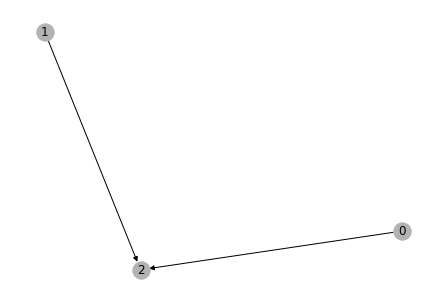

In [29]:
draw_graph(hg)

# 二、 公开数据集

In [33]:
def build_cora_dataset(add_symmetric_edges=True, add_self_loop=True):
    dataset = CoraGraphDataset()
    graph = dataset[0]

    train_mask = graph.ndata['train_mask']
    val_mask = graph.ndata['val_mask']
    test_mask = graph.ndata['test_mask']
    labels = graph.ndata['label']
    feat = graph.ndata['feat']

    if add_symmetric_edges:
        edges = graph.edges()
        graph.add_edges(edges[1], edges[0])

    graph = dgl.remove_self_loop(graph)
    if add_self_loop:
        graph = dgl.add_self_loop(graph)
    return graph

In [34]:
graph = build_cora_dataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [36]:
frontier = dgl.sampling.sample_neighbors(
                graph,
                2,
                fanout=2,
                edge_dir='in')

In [39]:
frontier

Graph(num_nodes=2708, num_edges=2,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [40]:
block = dgl.to_block(frontier, 2)

In [41]:
block

Block(num_src_nodes=3, num_dst_nodes=1, num_edges=2)

In [49]:
block.edata[dgl.EID]

tensor([0, 1])

In [48]:
for col, data in frontier.edata.items():
    print(col)
    print(data)

_ID
tensor([10566,  8132])


In [47]:
for col, data in graph.edata.items():
    print(col)
    print(data)
    print("=====")

In [38]:
dgl.EID

'_ID'